In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os
import pathlib
import sys
import pandas as pd
sys.path.append('../dataset/')
sys.path.append('../models/')
from PIL import Image
from unet import unet_2D, UNet
import torch
from catalyst import dl, metrics, utils;
import albumentations as A
from dataset import AsbestosDataSet
from torch.utils.data import DataLoader
from torch import nn
import datetime 
import pandas as pd

In [2]:
image_dir = '../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/images/asbestos/stones/lab_common_camera/'
mask_dir  = '../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/SegmentationAsbest'

transform = A.Compose([A.Resize(1152, 1728), A.RandomCrop(1024,1024), A.Resize(512,512) ,A.RandomRotate90()])
dataset = AsbestosDataSet(image_dir, mask_dir,transform)
validation_set = AsbestosDataSet('../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/validation/images',
                           '../../task_asbestos_stone_lab_common_camera-2021_12_10_13_12_14-mots png 1.0/validation/masks',
                           A.Compose([A.Resize(1152, 1728), A.RandomCrop(1024,1024), A.Resize(512,512)]))

data_loader = DataLoader(dataset, num_workers=1, batch_size = 2,)
validation_data_loader = DataLoader(validation_set, num_workers=1, batch_size = 2,)

loaders = {"train":data_loader, "valid":validation_data_loader}


Number of images and masks are different


In [3]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
    def forward(self, inputs, targets, smooth=1e-5):
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        return 1 - dice

In [4]:
import time

class CustomRunner(dl.Runner):
    def predict_batch(self, batch):
        return self.model(batch['image'].to(self.device))
    def on_loader_start(self, runner):
        super().on_loader_start(runner)
        self.meters = { key: metrics.AdditiveValueMetric(compute_on_call=True)
                        for key in ["loss", "iou"]}
        
    def handle_batch(self, batch):
        image, mask, name = batch.values()
        #----------
        time.sleep(0.12)
        image = image.unsqueeze(1)
        mask  = mask.unsqueeze(1)
#         mask  = torch.tensor(mask, dtype = torch.long)
        #------------
        predict = self.model(image)#batch size
#         print(image.shape, image.type(), mask.shape, mask.type())
        loss = self.criterion(predict, mask)
        #Создаем обьект
        iou_metric = metrics.IOUMetric()
        iou = iou_metric.update_key_value(predict, mask)['iou']
        self.batch_metrics.update(
            {"loss": loss, "iou": iou}
        )
        for key in ["loss", "iou"]:
            self.meters[key].update( self.batch_metrics[key].item(), self.batch_size)
        iou_metric.reset()
        if self.is_train_loader:
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            
    def on_loader_end(self, runner):
        for key in ["loss", "iou"]:
            self.loader_metrics[key] = self.meters[key].compute()[0]
        super().on_loader_end(runner)   

In [5]:
unet = UNet(n_channels=1, n_classes = 1 )
# unet = unet_2D(feature_scale=1, n_classes = 1, 
#                in_channels=1, is_deconv = True,
#                is_debug=False, )

In [ ]:
criterion = DiceLoss()
# criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(unet.parameters())
runner = CustomRunner()
runner.train(
    model=unet,
    criterion = criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=500, 
    logdir = 'unet_lab_log_{}'.format(str(datetime.datetime.now())),
    verbose=True)

/home/office/kirilman/miniconda3/lib/python3.8/site-packages/catalyst/core/runner.py:623: UserWarning: No ``ICriterionCallback/CriterionCallback`` were found while runner.criterion is not None.Do you compute the loss during ``runner.handle_batch``?
  warnings.warn(
/home/office/kirilman/miniconda3/lib/python3.8/site-packages/catalyst/core/runner.py:629: UserWarning: No ``IOptimizerCallback/OptimizerCallback`` were found while runner.optimizer is not None.Do run backward pass during ``runner.handle_batch``?
  warnings.warn(


/home/office/kirilman/miniconda3/lib/python3.8/site-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



train (1/500) iou: 0.05897066038515833 | loss: 0.8891631298595004



valid (1/500) iou: 0.05021339245140553 | loss: 0.9047295451164246
* Epoch (1/500) 



train (2/500) iou: 0.0761429982052909 | loss: 0.8596892522441015



valid (2/500) iou: 0.05689323544502258 | loss: 0.8926522016525269
* Epoch (2/500) 



train (3/500) iou: 0.08828472335719398 | loss: 0.8393622934818267



valid (3/500) iou: 0.06905435100197792 | loss: 0.8712467789649964
* Epoch (3/500) 



train (4/500) iou: 0.09754009534501366 | loss: 0.8241315086682637



valid (4/500) iou: 0.08675823360681534 | loss: 0.840752637386322
* Epoch (4/500) 



train (5/500) iou: 0.10357956347676614 | loss: 0.8150418864356147



valid (5/500) iou: 0.04393215514719486 | loss: 0.9159691810607911
* Epoch (5/500) 



train (6/500) iou: 0.13043881807890204 | loss: 0.7727432847023011



valid (6/500) iou: 0.05467393584549427 | loss: 0.8969589591026306
* Epoch (6/500) 



train (7/500) iou: 0.15299704174200693 | loss: 0.7389039927058749



valid (7/500) iou: 0.0526628665626049 | loss: 0.9000544786453247
* Epoch (7/500) 



train (8/500) iou: 0.15543613427629074 | loss: 0.7346927556726667



valid (8/500) iou: 0.1543166607618332 | loss: 0.7380438804626465
* Epoch (8/500) 



train (9/500) iou: 0.1815120050062736 | loss: 0.6995231045616996



valid (9/500) iou: 0.09380356520414353 | loss: 0.8289331197738647
* Epoch (9/500) 



train (10/500) iou: 0.19841201106707257 | loss: 0.6750056710508135



valid (10/500) iou: 0.1590360164642334 | loss: 0.7315938949584961
* Epoch (10/500) 



train (11/500) iou: 0.19598745026936135 | loss: 0.6784455312622919



valid (11/500) iou: 0.051224081218242644 | loss: 0.9025637149810791
* Epoch (11/500) 



train (12/500) iou: 0.19900224017005205 | loss: 0.6760217017597622



valid (12/500) iou: 0.1630737453699112 | loss: 0.724507212638855
* Epoch (12/500) 



train (13/500) iou: 0.20675108664565617 | loss: 0.663177063067754



valid (13/500) iou: 0.16580716967582704 | loss: 0.7241095423698425
* Epoch (13/500) 



train (14/500) iou: 0.21223556721169087 | loss: 0.6590093639161851



valid (14/500) iou: 0.08839474022388458 | loss: 0.8377305150032044
* Epoch (14/500) 



train (15/500) iou: 0.23426928992072743 | loss: 0.627793378300137



valid (15/500) iou: 0.09687406122684479 | loss: 0.8239701867103577
* Epoch (15/500) 



train (16/500) iou: 0.21818641862935492 | loss: 0.648163249095281



valid (16/500) iou: 0.07891901284456253 | loss: 0.8539755940437317
* Epoch (16/500) 



train (17/500) iou: 0.22356491742862597 | loss: 0.6396414869361454



valid (17/500) iou: 0.15304132401943207 | loss: 0.7381344079971314
* Epoch (17/500) 



train (18/500) iou: 0.24185067580805883 | loss: 0.6192666391531626



valid (18/500) iou: 0.1884140521287918 | loss: 0.7004863977432251
* Epoch (18/500) 



train (19/500) iou: 0.23816492408514023 | loss: 0.6225143273671467



valid (19/500) iou: 0.1930857241153717 | loss: 0.6920639753341675
* Epoch (19/500) 



train (20/500) iou: 0.24212565262698466 | loss: 0.619867742061615



valid (20/500) iou: 0.18214646875858306 | loss: 0.7001866698265076
* Epoch (20/500) 



train (21/500) iou: 0.25214617244071436 | loss: 0.6047397057215375



valid (21/500) iou: 0.18359346985816954 | loss: 0.6987310290336609
* Epoch (21/500) 



train (22/500) iou: 0.26765460520982737 | loss: 0.5846221248308816



valid (22/500) iou: 0.17034030556678773 | loss: 0.721132218837738
* Epoch (22/500) 



train (23/500) iou: 0.240292790863249 | loss: 0.6169080469343398



valid (23/500) iou: 0.04605374038219452 | loss: 0.912658441066742
* Epoch (23/500) 



train (24/500) iou: 0.2451960374083784 | loss: 0.6122097339895036



valid (24/500) iou: 0.17268425822257996 | loss: 0.7120630860328674
* Epoch (24/500) 



train (25/500) iou: 0.25948910911877954 | loss: 0.5959034595224594



valid (25/500) iou: 0.20177505910396576 | loss: 0.6772365093231201
* Epoch (25/500) 



train (26/500) iou: 0.2705909491827091 | loss: 0.5819451643360986



valid (26/500) iou: 0.2061970055103302 | loss: 0.6653927087783813
* Epoch (26/500) 



train (27/500) iou: 0.26639657053682536 | loss: 0.5863339073128171



valid (27/500) iou: 0.1269511193037033 | loss: 0.7779365658760071
* Epoch (27/500) 



train (28/500) iou: 0.24240275182657772 | loss: 0.6164122223854065



valid (28/500) iou: 0.18208563923835755 | loss: 0.6995693802833557
* Epoch (28/500) 



train (29/500) iou: 0.26719998444120097 | loss: 0.5838841100533801



valid (29/500) iou: 0.1673255980014801 | loss: 0.7190232276916504
* Epoch (29/500) 



train (30/500) iou: 0.25339841149333453 | loss: 0.603670166598426



valid (30/500) iou: 0.15814522802829742 | loss: 0.7444148063659668
* Epoch (30/500) 



train (31/500) iou: 0.27671961258682937 | loss: 0.5746336413754356



valid (31/500) iou: 0.1515762358903885 | loss: 0.7460264086723327
* Epoch (31/500) 



train (32/500) iou: 0.25265614150298965 | loss: 0.6026597850852542



valid (32/500) iou: 0.1567128688097 | loss: 0.7397493839263916
* Epoch (32/500) 



train (33/500) iou: 0.2566492594778538 | loss: 0.5982981688446469



valid (33/500) iou: 0.18990504145622253 | loss: 0.6864573717117309
* Epoch (33/500) 



train (34/500) iou: 0.2776558527515994 | loss: 0.5706660052140554



valid (34/500) iou: 0.18995440602302552 | loss: 0.7006094455718994
* Epoch (34/500) 



train (35/500) iou: 0.28813605362342465 | loss: 0.5637565056482952



valid (35/500) iou: 0.21849082112312318 | loss: 0.6549262285232544
* Epoch (35/500) 



train (36/500) iou: 0.2729665164111389 | loss: 0.581069979402754



valid (36/500) iou: 0.2068333625793457 | loss: 0.6688770771026611
* Epoch (36/500) 



train (37/500) iou: 0.30342555211649996 | loss: 0.541572289334403



valid (37/500) iou: 0.1297542154788971 | loss: 0.7832512617111206
* Epoch (37/500) 



train (38/500) iou: 0.2990338649186823 | loss: 0.5465688837899102



valid (38/500) iou: 0.21745160222053528 | loss: 0.6571691989898681
* Epoch (38/500) 



train (39/500) iou: 0.3009648418260945 | loss: 0.5453407631980051



valid (39/500) iou: 0.21294994354248048 | loss: 0.6591802835464478
* Epoch (39/500) 



train (40/500) iou: 0.32484883939226467 | loss: 0.5180619325902728



valid (40/500) iou: 0.21618165969848632 | loss: 0.6557521462440491
* Epoch (40/500) 



train (41/500) iou: 0.3295225004355113 | loss: 0.5121873584058549



valid (41/500) iou: 0.21529995203018187 | loss: 0.6531266450881958
* Epoch (41/500) 



train (42/500) iou: 0.3379764018787279 | loss: 0.4996087418662177



valid (42/500) iou: 0.16236389577388763 | loss: 0.7341096758842468
* Epoch (42/500) 



train (43/500) iou: 0.302204792905185 | loss: 0.5453739133146075



valid (43/500) iou: 0.21807906031608582 | loss: 0.6476643919944763
* Epoch (43/500) 



train (44/500) iou: 0.309789794186751 | loss: 0.5347104867299398



valid (44/500) iou: 0.1998409390449524 | loss: 0.6696702241897583
* Epoch (44/500) 



train (45/500) iou: 0.3167286117871603 | loss: 0.5231299499670664



valid (45/500) iou: 0.16537221670150756 | loss: 0.728791344165802
* Epoch (45/500) 



train (46/500) iou: 0.3059438657429483 | loss: 0.5396863189008501



valid (46/500) iou: 0.08102027624845505 | loss: 0.8505329012870788
* Epoch (46/500) 



train (47/500) iou: 0.33427393353647655 | loss: 0.5046118994553885



valid (47/500) iou: 0.2373864769935608 | loss: 0.6256778836250305
* Epoch (47/500) 



train (48/500) iou: 0.322156336158514 | loss: 0.5182086129983267



valid (48/500) iou: 0.18108875453472137 | loss: 0.709283447265625
* Epoch (48/500) 



train (49/500) iou: 0.3212604290909237 | loss: 0.5221443441179063



valid (49/500) iou: 0.1980712890625 | loss: 0.6864343881607056
* Epoch (49/500) 



train (50/500) iou: 0.33928043726417756 | loss: 0.49843022227287287



valid (50/500) iou: 0.27171315550804137 | loss: 0.5863562226295471
* Epoch (50/500) 



train (51/500) iou: 0.320505334271325 | loss: 0.520305057366689



valid (51/500) iou: 0.24867402911186218 | loss: 0.6068572282791138
* Epoch (51/500) 



train (52/500) iou: 0.34146900723377865 | loss: 0.49694761965009904



valid (52/500) iou: 0.22333772778511046 | loss: 0.6410713911056518
* Epoch (52/500) 



train (53/500) iou: 0.3231480833556917 | loss: 0.5229586660861969



valid (53/500) iou: 0.19005801975727082 | loss: 0.6910391092300415
* Epoch (53/500) 



train (54/500) iou: 0.3397728490332762 | loss: 0.4995687007904053



valid (54/500) iou: 0.18436232209205627 | loss: 0.692166543006897
* Epoch (54/500) 



train (55/500) iou: 0.3311558357543415 | loss: 0.5092685686217415



valid (55/500) iou: 0.23805838227272033 | loss: 0.6251463413238525
* Epoch (55/500) 



train (56/500) iou: 0.3548453400532404 | loss: 0.48008543252944946



valid (56/500) iou: 0.259164023399353 | loss: 0.5957789063453675
* Epoch (56/500) 



train (57/500) iou: 0.3383638651834594 | loss: 0.5019198391172621



valid (57/500) iou: 0.06903504878282547 | loss: 0.8711821794509887
* Epoch (57/500) 



train (58/500) iou: 0.32343438888589543 | loss: 0.5221911337640551



valid (58/500) iou: 0.2601992905139923 | loss: 0.5931362032890319
* Epoch (58/500) 



train (59/500) iou: 0.3705114929212465 | loss: 0.46787774893972606



valid (59/500) iou: 0.2830696225166321 | loss: 0.564631462097168
* Epoch (59/500) 



train (60/500) iou: 0.3644750987490018 | loss: 0.4755538801352183



valid (60/500) iou: 0.19051623344421387 | loss: 0.6915771961212158
* Epoch (60/500) 



train (61/500) iou: 0.35378938251071507 | loss: 0.4843677447901832



valid (61/500) iou: 0.2550720810890198 | loss: 0.5959863781929016
* Epoch (61/500) 



train (62/500) iou: 0.36476179709037143 | loss: 0.4729916950066884



valid (62/500) iou: 0.27594802975654603 | loss: 0.5792726278305054
* Epoch (62/500) 



train (63/500) iou: 0.34551861633857095 | loss: 0.4897909263769785



valid (63/500) iou: 0.2289018452167511 | loss: 0.6330934166908264
* Epoch (63/500) 


torch.Size([2, 1, 512, 512])


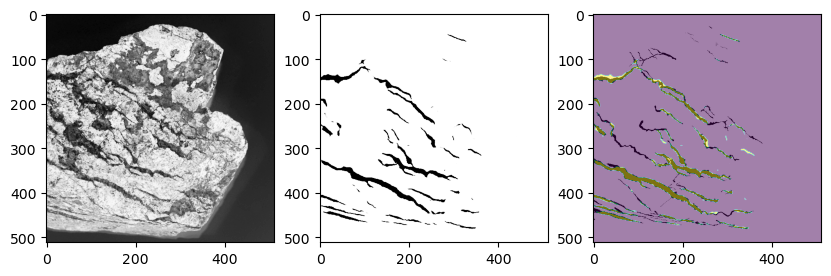

In [15]:
ex = next(data_loader.__iter__())
image = ex['image']
mask  = ex['mask']
# if image.shape[1] > 2:
#     image = image[0]
#     mask  = mask[0]

image = image.unsqueeze(1)
print(image.shape)
out = unet(image.to('cuda'))
pred_mask  = out[0][0].detach().cpu().numpy() 

fig, ax = plt.subplots(1,3, figsize = (10,10), dpi = 100)
ax[0].imshow(image[0][0].detach().cpu().numpy(), cmap='Greys')
ax[1].imshow(pred_mask, cmap='Greys')
ax[2].imshow(mask[0].detach().cpu().numpy(), cmap='Greys')
ax[2].imshow(pred_mask, alpha=0.5)

In [13]:
torch.cuda.empty_cache()

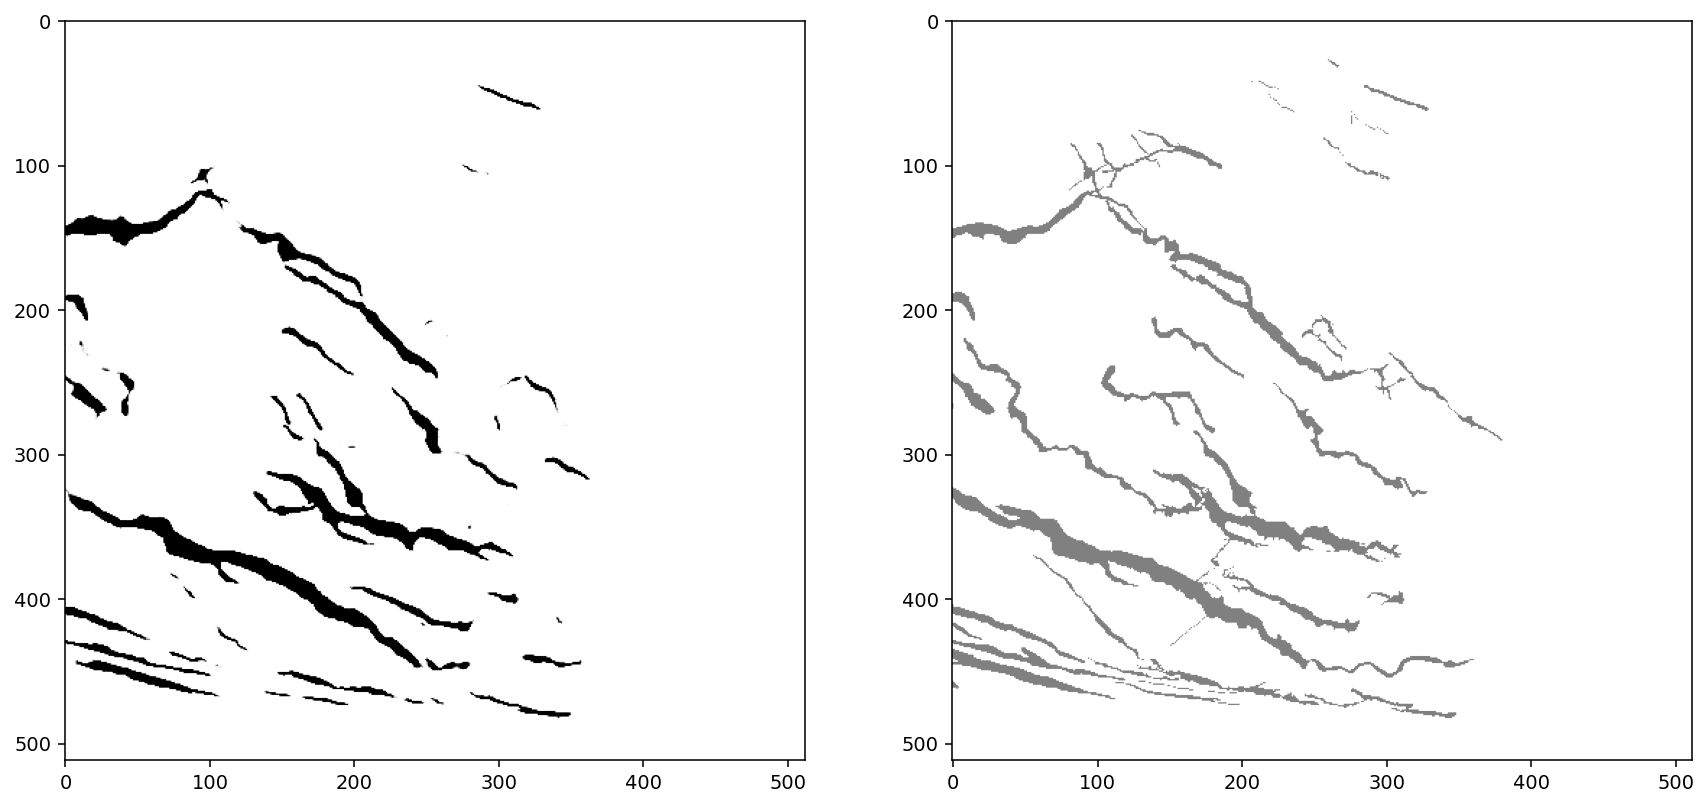

In [25]:
fig, ax = plt.subplots(1,2, figsize = (15,15), dpi = 140)
ax[0].imshow(pred_mask, cmap='Greys')
ax[1].imshow(mask[0].detach().cpu().numpy(), cmap='Greys', alpha = 0.5)

In [33]:
frame = pd.read_csv('unet_lab_log_2022-01-08 11:59:05.195936/logs/train.csv')
frame_val = pd.read_csv('unet_lab_log_2022-01-08 11:59:05.195936/logs/valid.csv')

<AxesSubplot:>

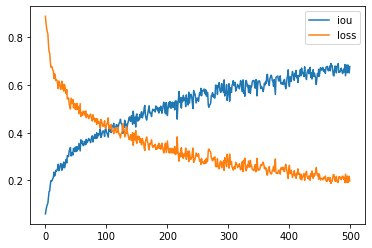

In [34]:
frame[['iou','loss']].plot()

<AxesSubplot:>

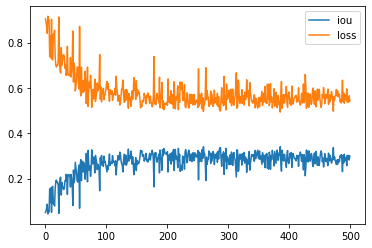

In [36]:
frame_val[['iou','loss']].plot()

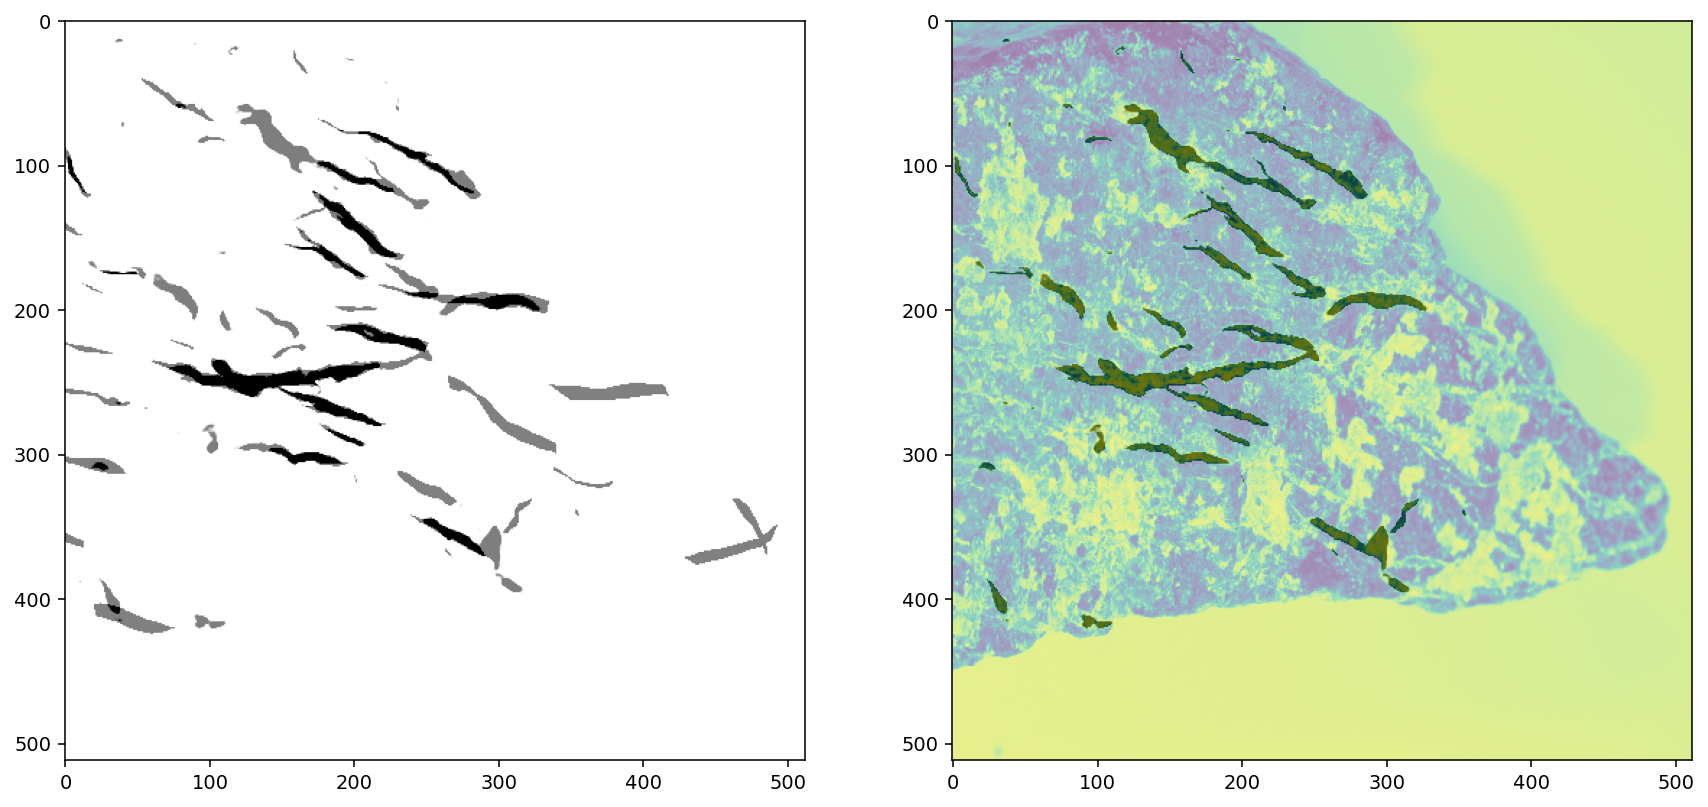

In [49]:
# ex = next(validation_data_loader.__iter__())
image = ex['image']
mask  = ex['mask']

image = image.unsqueeze(1)
out = unet(image.to('cuda'))
pred_mask  = out[0][0].detach().cpu().numpy() 
fig, ax = plt.subplots(1,2, figsize = (15,15), dpi = 140)
ax[0].imshow(pred_mask, cmap='Greys')
ax[0].imshow(mask[0].detach().cpu().numpy(), cmap='Greys', alpha = 0.5)
ax[1].imshow(image[0][0].detach().cpu().numpy())
ax[1].imshow(pred_mask, cmap='Greys',  alpha = 0.5)